In [1]:
import urllib2

def read_scoring_matrix(filename):
    """
    Read a scoring matrix from the file named filename.  

    parameter
    ---------
    filename: name of file containing a scoring matrix

    return
    ------
    A dictionary of dictionaries mapping X and Y characters to scores
    """
    scoring_dict = {}
    scoring_file = urllib2.urlopen(filename)
    ykeys = scoring_file.readline()
    ykeychars = ykeys.split()
    for line in scoring_file.readlines():
        vals = line.split()
        xkey = vals.pop(0)
        scoring_dict[xkey] = {}
        for ykey, val in zip(ykeychars, vals):
            scoring_dict[xkey][ykey] = int(val)
    return scoring_dict


def read_protein(filename):
    """
    Read a protein sequence from the file named filename.

    parameter
    ---------
    filename: name of file containing a protein sequence

    return
    ------
    A string representing the protein
    """
    protein_file = urllib2.urlopen(filename)
    protein_seq = protein_file.read()
    protein_seq = protein_seq.rstrip()
    return protein_seq


def read_words(filename):
    """
    Load word list from the file named filename.

    Returns a list of strings.
    """
    word_file = urllib2.urlopen(filename)
    words = word_file.read()
    word_list = words.split('\n')
    print "Loaded a dictionary with", len(word_list), "words"
    return word_list

In [2]:
# URLs for data files
PAM50_URL = "http://storage.googleapis.com/codeskulptor-alg/alg_PAM50.txt"
HUMAN_EYELESS_URL = "http://storage.googleapis.com/codeskulptor-alg/alg_HumanEyelessProtein.txt"
FRUITFLY_EYELESS_URL = "http://storage.googleapis.com/codeskulptor-alg/alg_FruitflyEyelessProtein.txt"
CONSENSUS_PAX_URL = "http://storage.googleapis.com/codeskulptor-alg/alg_ConsensusPAXDomain.txt"
WORD_LIST_URL = "http://storage.googleapis.com/codeskulptor-assets/assets_scrabble_words3.txt"

# Comparing

In [3]:
from alignment import compute_alignment_matrix, compute_local_alignment

seq_human = read_protein(HUMAN_EYELESS_URL)
seq_ff = read_protein(FRUITFLY_EYELESS_URL)
scores = read_scoring_matrix(PAM50_URL)
aligns = compute_alignment_matrix(seq_human, seq_ff, scores, False)
local_score, sl_human, sl_ff = compute_local_alignment(seq_human, seq_ff, scores, aligns)

print local_score
print sl_human
print sl_ff

875
HSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRILQVSNGCVSKILGRYYETGSIRPRAIGGSKPRVATPEVVSKIAQYKRECPSIFAWEIRDRLLSEGVCTNDNIPSVSSINRVLRNLASEK-QQ
HSGVNQLGGVFVGGRPLPDSTRQKIVELAHSGARPCDISRILQVSNGCVSKILGRYYETGSIRPRAIGGSKPRVATAEVVSKISQYKRECPSIFAWEIRDRLLQENVCTNDNIPSVSSINRVLRNLAAQKEQQ


In [5]:
import numpy as np
from alignment import compute_global_alignment

seq_human = sl_human.replace('-', '')
seq_css = read_protein(CONSENSUS_PAX_URL)
aligns = compute_alignment_matrix(seq_human, seq_css, scores, True)
score, ahuman, acss = compute_global_alignment(seq_human, seq_css, scores, aligns)

matched_pct = (np.array(list(ahuman)) == np.array(list(acss))).sum() / float(len(ahuman))
print ahuman
print acss
print 'Matched Pct, Human vs PAX = {:.3f}%'.format(matched_pct*100)
print score / float(len(ahuman))
print 


seq_ff = sl_ff.replace('-', '')
seq_css = read_protein(CONSENSUS_PAX_URL)
aligns = compute_alignment_matrix(seq_ff, seq_css, scores, True)
score, aff, acss = compute_global_alignment(seq_ff, seq_css, scores, aligns)

matched_pct = (np.array(list(aff)) == np.array(list(acss))).sum() / float(len(aff))
print aff
print acss
print 'Matched Pct, FruitFly vs PAX = {:.3f}%'.format(matched_pct*100)
print score / float(len(aff))

-HSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRILQVSNGCVSKILGRYYETGSIRPRAIGGSKPRVATPEVVSKIAQYKRECPSIFAWEIRDRLLSEGVCTNDNIPSVSSINRVLRNLASEKQQ
GHGGVNQLGGVFVNGRPLPDVVRQRIVELAHQGVRPCDISRQLRVSHGCVSKILGRYYETGSIKPGVIGGSKPKVATPKVVEKIAEYKRQNPTMFAWEIRDRLLAERVCDNDTVPSVSSINRIIR--------
Matched Pct, Human vs PAX = 72.932%
4.60902255639

-HSGVNQLGGVFVGGRPLPDSTRQKIVELAHSGARPCDISRILQVSNGCVSKILGRYYETGSIRPRAIGGSKPRVATAEVVSKISQYKRECPSIFAWEIRDRLLQENVCTNDNIPSVSSINRVLRNLAAQKEQQ
GHGGVNQLGGVFVNGRPLPDVVRQRIVELAHQGVRPCDISRQLRVSHGCVSKILGRYYETGSIKPGVIGGSKPKVATPKVVEKIAEYKRQNPTMFAWEIRDRLLAERVCDNDTVPSVSSINRIIR---------
Matched Pct, FruitFly vs PAX = 70.149%
4.37313432836


The random probability for a string over 100+ size has over 70% ordered similiarty with PAX domain choosing from a set of 23 alphabets is nearly zero.
Thus, the two sequences must had some commonality from the ancestors.

# Hypothesis Testing

In [4]:
import random
from alignment import compute_alignment_matrix, compute_local_alignment


def generate_null_distribution(seq_x, seq_y, scores, ntrials):
    dist = {}
    rand_y = list(str(seq_y))

    for trial_i in range(ntrials):
        random.shuffle(rand_y)
        _rand_y = ''.join(rand_y)
        aligns = compute_alignment_matrix(seq_x, _rand_y, scores, False)
        score, slx, sly = compute_local_alignment(seq_x, _rand_y, scores, aligns)
        dist[score] = dist.get(score, 0) + 1
    
    return dist

dist = generate_null_distribution(seq_human, seq_ff, scores, 1000)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def dist_mean(dist):
    mu = (dist.index.values * dist.values).sum()
    return mu

def dist_moment(dist, moment=2):
    mu = dist_mean(dist)
    m = np.sum((dist.index.values - mu) ** moment * dist.values) ** (1/moment)
    return m
    
pmf = pd.Series(dist)
pmf = pmf / pmf.sum()

Mean = 51.891000000000005 Std = 6.7908113653671744
Zscore = 121.2092275450056


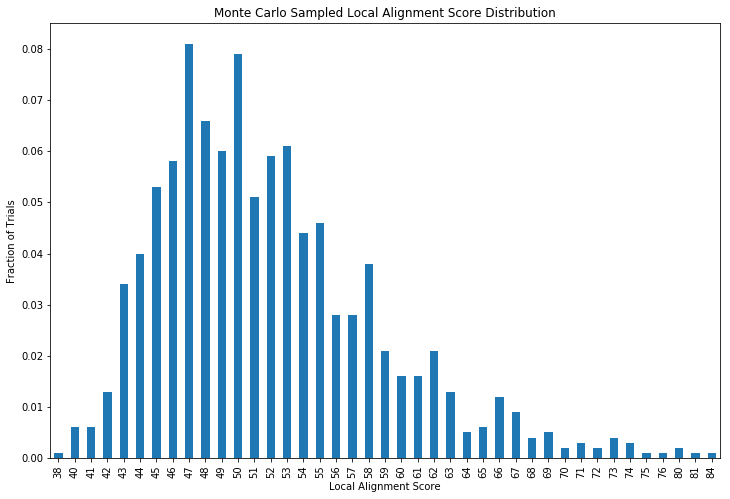

In [101]:
mu = dist_mean(pmf)
std = dist_moment(pmf, 2.0)
zscore = (local_score - mu) / std

print 'Mean =', mu, 'Std =', std
print 'Zscore =', zscore

pmf.plot(kind='bar', figsize=(12,8))
plt.title('Monte Carlo Sampled Local Alignment Score Distribution')
plt.xlabel('Local Alignment Score')
plt.ylabel('Fraction of Trials')
plt.show()

Under the assumption of a normal distribution, given a zscore around 120, the probability of two sequences (human vs fruitfly eyeless) have such large similarities has nearly 0 chance. 

# Speeling Correction

In [90]:
from alignment import build_scoring_matrix, compute_global_alignment, compute_alignment_matrix


def edit_distance(seq_x, seq_y, scores):
    aligns = compute_alignment_matrix(seq_x, seq_y, scores, True)
    score, _, _ = compute_global_alignment(seq_x, seq_y, scores, aligns)
    return len(seq_x) + len(seq_y) - score


words = set(read_words(WORD_LIST_URL))

_w = ''
for w in words:
    _w += w
alph = set(_w)
scores = build_scoring_matrix(alph, 2, 1, 0)

Loaded a dictionary with 79340 words


In [98]:
def check_spelling(checked_word, dist, words):
    global scores

    res = set()
    for word in words:
        _dist = edit_distance(checked_word, word, scores)
        if _dist <= dist:
            res.add(word)
    return res

In [96]:
check_spelling('humble', 1, words)

{'bumble',
 'fumble',
 'humble',
 'humbled',
 'humbler',
 'humbles',
 'humbly',
 'jumble',
 'mumble',
 'rumble',
 'tumble'}

In [97]:
check_spelling('firefly', 2, words)

{'direly',
 'finely',
 'fireclay',
 'firefly',
 'firmly',
 'firstly',
 'fixedly',
 'freely',
 'liefly',
 'refly',
 'tiredly'}

Q9:
The tricks are two:
- first, store all correct words in a set, so the lookup time becomes O(1). If the word it not in the word_list, it is not valid; thus, stop the operation.
- second, instead of correct edit distance between all possible valid words, generate all possible 1 edit changes on the given word and check validility in the word_list. Then 2nd edit could be done given the 1st edit's valid mutations.